## Problem Statement:

__About Company__ <br>
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

__Problem__ <br>
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

#### Dataset Description:

| Variable | Description | 
|------|------|
| Loan_ID | Unique Loan ID | 
| Gender | Male/ Female | 
| Married | Applicant married (Y/N) | 
| Dependents | Number of dependents | 
| Education | Applicant Education (Graduate/ Under Graduate) | 
| Self_Employed | Self employed (Y/N) | 
| ApplicantIncome | Applicant income | 
| CoapplicantIncome | Coapplicant income | 
| LoanAmount | Loan amount in thousands | 
| Loan_Amount_Term | Term of loan in months | 
| Credit_History | credit history meets guidelines | 
| Property_Area | Urban/ Semi Urban/ Rural | 
| Loan_Status | Loan approved (Y/N) | 

## Piepline Workflow:
This is an end-to-end binary classification example following the steps:
- Part 1: Fetch data using SQL query from data sources via Airflow DAG
- Part 2: Load data from object store and process it labelling and imputing missing values to data
- Part 3: Train model on dataset with various classification methods and track model components with MLflow
- Part 4: Get the best model and Deploy model with KServe (Kubeflow)


Here's the end-to-end information flow

<img src="./loan-predict-workflow.png" width="80%">


#### Import dependencies and load data

In [ ]:
import requests
EZAF_ENV = "hpe-staging-ezaf"
token_url = f"https://keycloak.{EZAF_ENV}.com/realms/UA/protocol/openid-connect/token"

data = {
    "username" : input("Enter username."),
    "password" : input("Enter password."),
    "grant_type" : "password",
    "client_id" : "ua-grant",
}

token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

token = token_responce.json()["access_token"]

minio_username = input("Enter data fabric object store Access Key.")
minio_password = input("Enter data fabric object store Secret Access Key.")

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns #importing seaborn module 
import warnings
import os, joblib, operator
from sklearn.model_selection import train_test_split,KFold, cross_val_score, cross_val_predict,cross_validate
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from minio import Minio
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.tracking import MlflowClient
import mlflow, urllib3
import subprocess
# from mlflow import pyfunc

warnings.filterwarnings('ignore')  #this will ignore the warnings.it wont display warnings in notebook
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=[6,3]
plt.rcParams['figure.dpi']=80

os.environ["BUCKET"] = "ezaf-demo"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://home.hpe-staging-ezaf.com:31900"
os.environ["AWS_ACCESS_KEY_ID"] = minio_username
os.environ["AWS_SECRET_ACCESS_KEY"] = minio_password
os.environ['MLFLOW_TRACKING_TOKEN'] = token
os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow.hpe-staging-ezaf.com"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
os.environ["MLFLOW_S3_IGNORE_TLS"] = "true"

In [13]:
# Adding package to env
# pip_reqs = mlflow.sklearn.get_default_pip_requirements()
# pip_reqs += ['dill']

EXPERIMENT_NAME = "Loan-Prediction-Demo3"
mlflow.set_experiment(EXPERIMENT_NAME)
EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# print(os.getenv("MLFLOW_S3_ENDPOINT_URL").replace("https://",""))
# print(os.getenv("AWS_ACCESS_KEY_ID"))
# print(os.getenv("AWS_SECRET_ACCESS_KEY"))

client = Minio(
    endpoint=os.getenv("MLFLOW_S3_ENDPOINT_URL").replace("https://",""),
    access_key=os.getenv("AWS_ACCESS_KEY_ID"),
    secret_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE')
)



train_obj = client.get_object(os.getenv("BUCKET"),"/data/loan-approval/train.csv")
train_df = pd.read_csv(train_obj)
print(train_df)

test_obj = client.get_object(os.getenv("BUCKET"),"/data/loan-approval/test.csv")
test_df = pd.read_csv(test_obj)

      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0         NaN           

In [14]:
#pre-processing
#Dropping unwanted columns - Loan_ID
train_df.drop(['Loan_ID'],axis=1,inplace=True)
test_df.drop(['Loan_ID'],axis=1,inplace=True)

#Convert target variable to integer
train_df['Loan_Status'] = train_df['Loan_Status'].map({'N':0,'Y':1})

#### Let's explore the data

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [16]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


In [17]:
train_df.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
448,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,0
64,Female,No,0,Graduate,No,4166,0.0,116.0,360.0,0.0,Semiurban,0
442,Male,No,3+,Not Graduate,No,4707,1993.0,148.0,360.0,1.0,Semiurban,1
270,Female,No,0,Graduate,No,3237,0.0,30.0,360.0,1.0,Urban,1
188,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,1


Check distribution of target variable

In [18]:
train_df.Loan_Status.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

**Missing data**

Let's see here how much data is missing. We will have to fill the missing features later on.

In [19]:
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent_1 = df.isnull().sum()/df.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

##### Training Data

In [20]:
get_missing_data(train_df)

,Total,%
Credit_History,50,8.1
Self_Employed,32,5.2
LoanAmount,22,3.6
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5
Education,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0


##### Testing Data

In [21]:
get_missing_data(test_df)

,Total,%
Credit_History,29,7.9
Self_Employed,23,6.3
Gender,11,3.0
Dependents,10,2.7
Loan_Amount_Term,6,1.6
LoanAmount,5,1.4
Married,0,0.0
Education,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0


### EDA

<AxesSubplot:xlabel='Dependents', ylabel='count'>

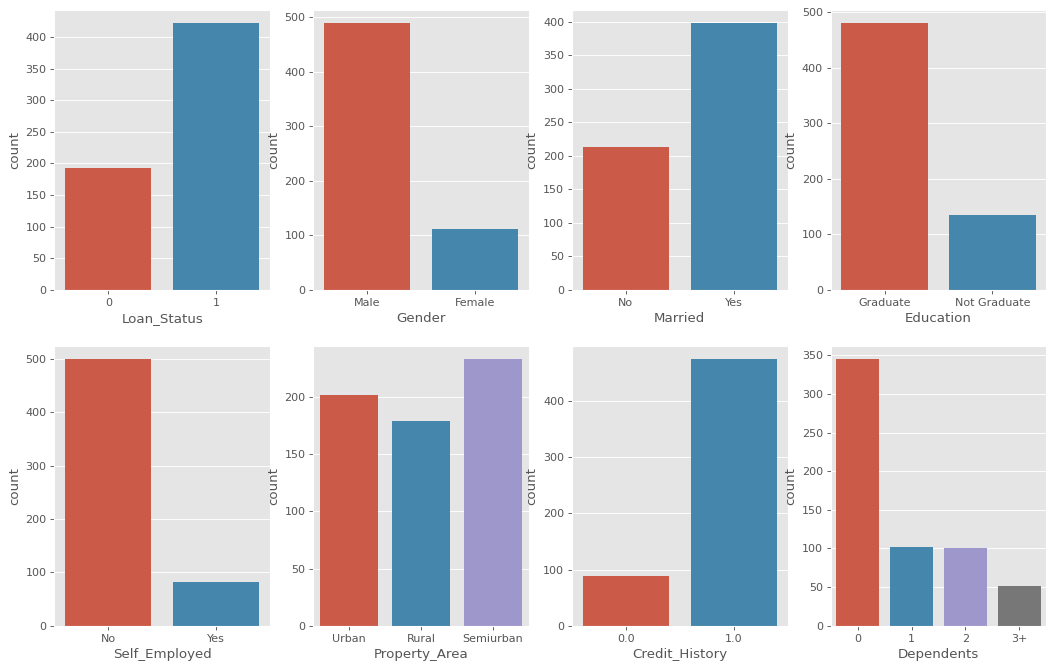

In [22]:
#Univariate Analysis
fig,ax = plt.subplots(2,4,figsize=(16,10))
sns.countplot('Loan_Status',data=train_df,ax=ax[0][0])
sns.countplot('Gender',data=train_df,ax=ax[0][1])
sns.countplot('Married',data=train_df,ax=ax[0][2])
sns.countplot('Education',data=train_df,ax=ax[0][3])
sns.countplot('Self_Employed',data=train_df,ax=ax[1][0])
sns.countplot('Property_Area',data=train_df,ax=ax[1][1])
sns.countplot('Credit_History',data=train_df,ax=ax[1][2])
sns.countplot('Dependents',data=train_df,ax=ax[1][3])

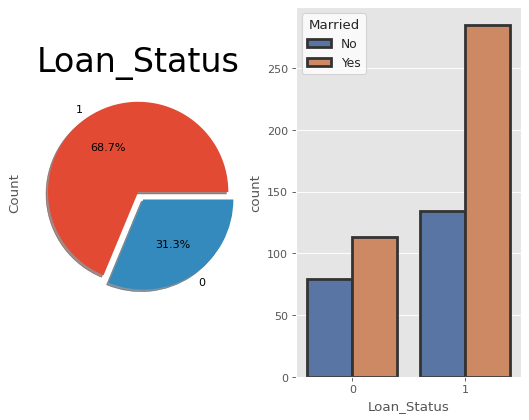

In [23]:
# Explore variable 'Married' with target variable - 'Loan_Status'

f,ax=plt.subplots(1,2,figsize=(8,6))
train_df['Loan_Status'].value_counts().plot.pie(ax=ax[0],explode=[0,0.1],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Loan_Status',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Loan_Status',hue='Married',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [24]:
#Catplot - 'Married' Vs 'Loan_Status' 
sns.catplot(x='Married',y='Loan_Status',kind='point',data=train_df)

#If you are married, then chances of getting loan approved are more (71.8%) than if you are not married (62.9%).

In [25]:
#Catplot - 'Gender' Vs 'Loan_Status' with hue='Education' and columns = 'Property_Area'
sns.catplot(x='Gender',y='Loan_Status',kind='bar',data=train_df,col='Property_Area',hue='Education')

In [26]:
# Variable - 'Education' Vs 'Loan_Status'
f,ax=plt.subplots(1,2,figsize=(10,8))
train_df['Education'].value_counts().plot.pie(ax=ax[0],explode=[0,0.1],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Education',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Education',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [27]:
#Catplot - 'Education' Vs 'Loan_Status'
sns.catplot(x='Education',y='Loan_Status',kind='bar',data=train_df,col='Married',hue='Property_Area')

#If you are in urban+Not graduate+not married = Loan approval is less

In [28]:
# Variable - 'Property_Area' Vs 'Loan_Status'
f,ax=plt.subplots(1,2,figsize=(8,6))
train_df['Property_Area'].value_counts().plot.pie(ax=ax[0],explode=[0,0,0.1],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Property_Area',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Property_Area',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [29]:
#Catplot - 'Property_Area' Vs 'Loan_Status'
sns.catplot(x='Property_Area',y='Loan_Status',kind='bar',data=train_df)

#If you are in semiurban, then chances of getting loan approved are more (76.8%) than if you are in urban(65.8%) & Rural (61.5%)

In [30]:
# Variable - 'Gender'  Vs 'Loan_Status'
f,ax=plt.subplots(1,2,figsize=(10,6))
train_df['Gender'].value_counts().plot.pie(ax=ax[0],explode=[0,0.1],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Gender',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Gender',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [31]:
# Variable - 'Gender'  Vs 'ApplicantIncome' & hue = Loan_Status, col = Proprty_Area
sns.catplot(x='Gender',y='ApplicantIncome',data=train_df,kind='boxen',hue='Loan_Status', col='Property_Area')

In [32]:
# Variable - 'Gender'  Vs 'CoapplicantIncome'
sns.catplot(x='Gender',y='CoapplicantIncome',data=train_df,kind='box')

#Mean CoapplicantIncome of male slightly higer than Females.

In [33]:
# Variable - 'Gender'  Vs 'CoapplicantIncome' with hue=Loan_Status and col=Property_Area
sns.catplot(x='Gender',y='CoapplicantIncome',data=train_df,kind='boxen',hue='Loan_Status', col='Property_Area')

#Male have higher co-applicant income than female in all three property areas

In [34]:
# Variable - 'Dependents' Vs 'Loan_Status'
f,ax=plt.subplots(1,2,figsize=(8,6))
train_df['Dependents'].value_counts().plot.pie(ax=ax[0],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Dependents',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Dependents',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [35]:
# Variable - 'Credit_History' Vs 'Loan_Status'
f,ax=plt.subplots(1,2,figsize=(8,6))
train_df['Credit_History'].value_counts().plot.pie(ax=ax[0],shadow=True,autopct='%1.1f%%')
ax[0].set_title('Credit_History',fontsize=30)
ax[0].set_ylabel('Count')
sns.set(font="Verdana")
sns.set_style("ticks")
sns.countplot('Credit_History',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df,ax=ax[1])
plt.ioff()

In [36]:
# Variable - 'Credit_History' Vs 'Loan_Status'
sns.catplot(x='Credit_History',y='Loan_Status',kind='bar',data=train_df)

#If credit history is 1 then high chances (79.6%) of getting loan approved than 7.9% for credit history = 0

In [37]:
# Variable - 'Gender' Vs 'LoanAmount'
sns.catplot(x='Gender',y='LoanAmount',data=train_df,kind='box')

#Mean LoanAmount of male slightly higer than Females.

In [38]:
# Variable - 'Self_Employed' Vs 'LoanAmount'
sns.catplot(x='Self_Employed',y='LoanAmount',data=train_df,kind='box')

#If you are self employed then loan amount is higher

In [39]:
# Variable - 'Gender' Vs 'LoanAmount', hue='Loan_Status', col='Married'
sns.catplot(x='Gender',y='LoanAmount',data=train_df,kind='box',hue='Loan_Status', col='Married')

#If you are married then loan amount is slightly higher then non-married

In [40]:
# Variable - 'Loan_Amount_Term' Vs 'Loan_Status'
sns.countplot('Loan_Amount_Term',hue='Loan_Status',linewidth=2.5,edgecolor=".2",data=train_df)

#Maximum customers went for 360 months

<AxesSubplot:title={'center':'Married = Yes'}, xlabel='Loan_Amount_Term', ylabel='count'>

### DATA PROCESSING

#### Imputing missing values

In [41]:
#Column - Married. Fill Null values with mode of Married column
train_df['Married'].value_counts().index[0]
train_df['Married'].fillna(train_df['Married'].value_counts().index[0], inplace=True)
test_df['Married'].fillna(test_df['Married'].value_counts().index[0], inplace=True)

#Column - Dependents. 
#If loan status is 1 then, dependent = 2 else dependent=1 for train 
train_df.loc[(train_df.Dependents.isnull())&(train_df.Loan_Status==1),'Dependents'] = '2'
train_df.loc[(train_df.Dependents.isnull()),'Dependents'] = '1'
#If Credit_History is 1 then, dependent = 2 else dependent=1 for test
test_df.loc[(test_df.Dependents.isnull())&(test_df.Credit_History==1),'Dependents'] = '2'
test_df.loc[(test_df.Dependents.isnull()),'Dependents'] = '1'

#Column - Credit_History
# If loan status is 1 then, Credit_History = 1 else Credit_History=0
train_df.loc[(train_df.Credit_History.isnull())&(train_df.Loan_Status==1),'Credit_History'] = 1
train_df.loc[(train_df.Credit_History.isnull()),'Credit_History'] = 0
# Fill Null values with mode of Credit_History column for test
test_df['Credit_History'].fillna(test_df['Credit_History'].value_counts().index[0], inplace=True)
#In test data, for the user with income = 2733, it was decided to impute credit history as 0 based upon the Income to loan ratio 
test_df.loc[(test_df.ApplicantIncome == 2733),'Credit_History']  = 0

#Column - Gender
# Fill Null values with mode of Gender column
train_df['Gender'].fillna(train_df['Gender'].value_counts().index[0], inplace=True)
test_df['Gender'].fillna(test_df['Gender'].value_counts().index[0], inplace=True)

#Column - Self_Employed
# If Credit_History is 1 then, impute Self_Employed = No else Yes
train_df.loc[(train_df.Self_Employed.isnull())&(train_df.Credit_History==1),'Self_Employed'] ='No'
train_df.loc[(train_df.Self_Employed.isnull()),'Self_Employed'] = 'Yes'
# If Credit_History is 1 then, impute Self_Employed = No else Yes for test
test_df.loc[(test_df.Self_Employed.isnull())&(test_df.Credit_History==1),'Self_Employed'] ='No'
test_df.loc[(test_df.Self_Employed.isnull()),'Self_Employed'] = 'Yes'

#Column - Loan_Amount_Term. 
#Loan_Amount_Term depends upon gender, married, education, self employed and dependent columns. 
#Hence we will group them by above columns and imput median values. In case if the median is null then we will impute median of the entire Loan_Amount_Term column
#get the index of the null columns for Loan_Amount_Term - train
index_NaN_Loan_Amount_Term = list(train_df["Loan_Amount_Term"][train_df["Loan_Amount_Term"].isnull()].index)

for i in index_NaN_Loan_Amount_Term :
    Loan_Amount_Term_med = train_df["Loan_Amount_Term"].median() # find median of entire Loan_Amount_Term column
    Loan_Amount_Term_pred = train_df["Loan_Amount_Term"][((train_df['Gender'] == train_df.iloc[i]["Gender"])
                                                      & (train_df['Married'] == train_df.iloc[i]["Married"])
                                                      & (train_df['Education'] == train_df.iloc[i]["Education"])
                                                      & (train_df['Self_Employed'] == train_df.iloc[i]["Self_Employed"])
                                                      & (train_df['Dependents'] == train_df.iloc[i]["Dependents"]))].median()
    if not np.isnan(Loan_Amount_Term_pred) :
        train_df['Loan_Amount_Term'].iloc[i] = Loan_Amount_Term_pred
    else :
        train_df['Loan_Amount_Term'].iloc[i] = Loan_Amount_Term_med

#Impute Loan term  amount for test
index_NaN_Loan_Amount_Term_test = list(test_df["Loan_Amount_Term"][test_df["Loan_Amount_Term"].isnull()].index)

for i in index_NaN_Loan_Amount_Term_test :
    Loan_Amount_Term_med = test_df["Loan_Amount_Term"].median() 
    Loan_Amount_Term_pred = test_df["Loan_Amount_Term"][(( test_df['Gender'] == test_df.iloc[i]["Gender"])
                                                         & (test_df['Married'] == test_df.iloc[i]["Married"])
                                                         & (test_df['Education'] == test_df.iloc[i]["Education"])
                                                         & (test_df['Self_Employed'] == test_df.iloc[i]["Self_Employed"])
                                                         & (test_df['Dependents'] == test_df.iloc[i]["Dependents"]))].median()
    if not np.isnan(Loan_Amount_Term_pred) :
        test_df['Loan_Amount_Term'].iloc[i] = Loan_Amount_Term_pred
    else :
        test_df['Loan_Amount_Term'].iloc[i] = Loan_Amount_Term_med

In [42]:
# Variable - LoanAmount - Identify on which other columns LoanAmount depends
# Explore LoanAmount vs categorical variables
g = sns.factorplot(y="LoanAmount",x="Credit_History",data=train_df,kind="box",hue="Gender")
g = sns.factorplot(y="LoanAmount",x="Property_Area",data=train_df,kind="box", hue="Dependents")
g = sns.factorplot(y="LoanAmount",x="Gender", data=train_df,kind="box",hue="Married")
g = sns.factorplot(y="LoanAmount",x="Married", data=train_df,kind="box")
g = sns.factorplot(y="LoanAmount",x="Education", data=train_df,kind="box")
g = sns.factorplot(y="LoanAmount",x="Self_Employed", data=train_df,kind="box")
g = sns.factorplot(y="LoanAmount",x="Dependents", data=train_df,kind="box")

In [43]:
#Column - LoanAmount. LoanAmount depends upon Property_Area, gender, married, education, self employed and dependent columns. 
# Hence we will group them by above columns and imput median values. In case if the median is null then we will impute median of the entire LoanAmount column.

#Impute LoanAmount for train
index_NaN_LoanAmount = list(train_df["LoanAmount"][train_df["LoanAmount"].isnull()].index)

for i in index_NaN_LoanAmount :
    LoanAmount_med = train_df["LoanAmount"].median() # find median of entire LoanAmount column
    LoanAmount_pred = train_df["LoanAmount"][((train_df['Property_Area'] == train_df.iloc[i]["Property_Area"])
                                          & (train_df['Gender'] == train_df.iloc[i]["Gender"])
                                          & (train_df['Married'] == train_df.iloc[i]["Married"])
                                          & (train_df['Education'] == train_df.iloc[i]["Education"])
                                          & (train_df['Self_Employed'] == train_df.iloc[i]["Self_Employed"])
                                          & (train_df['Dependents'] == train_df.iloc[i]["Dependents"]))].median()
    if not np.isnan(LoanAmount_pred) :
        train_df['LoanAmount'].iloc[i] = LoanAmount_pred
    else :
        train_df['LoanAmount'].iloc[i] = LoanAmount_med
        
#Impute Loan amount for test
index_NaN_LoanAmount_test = list(test_df["LoanAmount"][test_df["LoanAmount"].isnull()].index)

for i in index_NaN_LoanAmount_test :
    LoanAmount_med = test_df["LoanAmount"].median()
    LoanAmount_pred = test_df["LoanAmount"][((test_df['Property_Area'] == test_df.iloc[i]["Property_Area"])
                                          & (test_df['Gender'] == test_df.iloc[i]["Gender"])
                                          & (test_df['Married'] == test_df.iloc[i]["Married"])
                                          & (test_df['Education'] == test_df.iloc[i]["Education"])
                                          & (test_df['Self_Employed'] == test_df.iloc[i]["Self_Employed"])
                                          & (test_df['Dependents'] == test_df.iloc[i]["Dependents"]))].median()
    if not np.isnan(LoanAmount_pred) :
        test_df['LoanAmount'].iloc[i] = LoanAmount_pred
    else :
        test_df['LoanAmount'].iloc[i] = LoanAmount_med

##### Check for any missing values

##### Training Data

In [44]:
get_missing_data(train_df)

,Total,%
Gender,0,0.0
Married,0,0.0
Dependents,0,0.0
Education,0,0.0
Self_Employed,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0
LoanAmount,0,0.0
Loan_Amount_Term,0,0.0
Credit_History,0,0.0


##### Testing Data

In [45]:
get_missing_data(test_df)

,Total,%
Gender,0,0.0
Married,0,0.0
Dependents,0,0.0
Education,0,0.0
Self_Employed,0,0.0
ApplicantIncome,0,0.0
CoapplicantIncome,0,0.0
LoanAmount,0,0.0
Loan_Amount_Term,0,0.0
Credit_History,0,0.0


#### Label encode categorical variables

In [46]:
train_df["Dependents"] = train_df["Dependents"].map({"0": 0, "1": 1,"2": 2, "3+": 3})
train_df["Property_Area"] = train_df["Property_Area"].map({"Rural":0, "Semiurban":1, "Urban": 2,})

test_df["Dependents"] = test_df["Dependents"].map({"0": 0, "1": 1,"2": 2, "3+": 3})
test_df["Property_Area"] = test_df["Property_Area"].map({"Rural":0, "Semiurban":1, "Urban": 2,})

#### Since LoanAmount is in thousands, lets multiply LoanAmount column with 1000

In [47]:
train_df['LoanAmount'] = train_df['LoanAmount'] * 1000
test_df['LoanAmount'] = test_df['LoanAmount'] * 1000

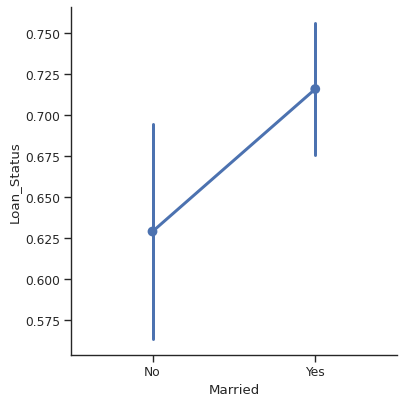

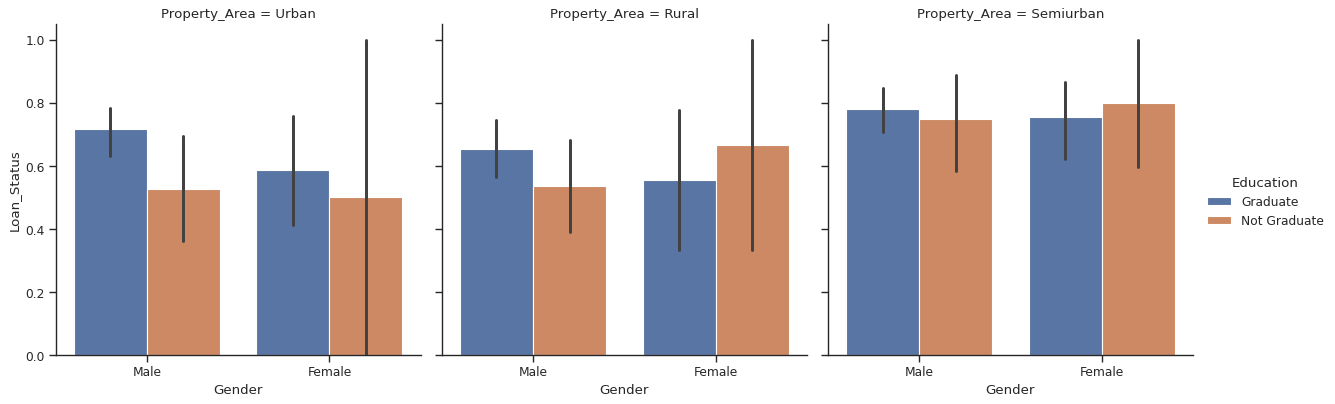

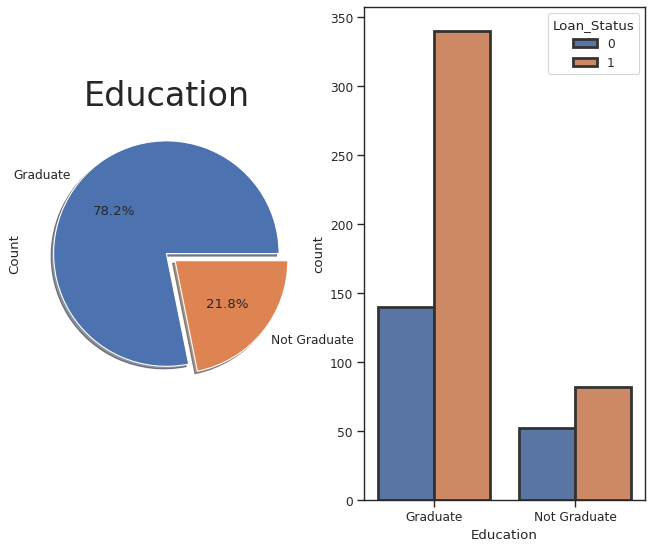

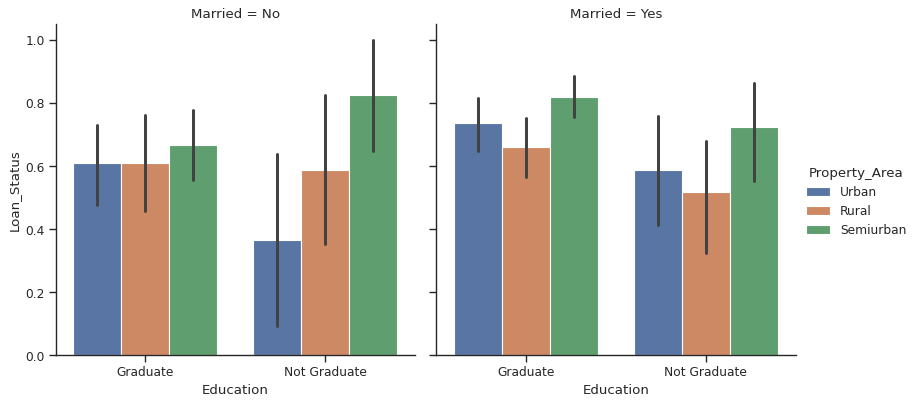

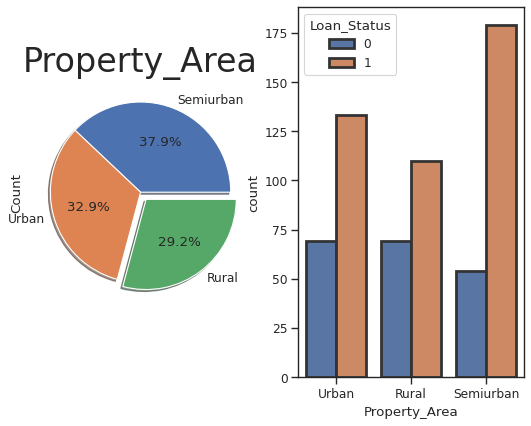

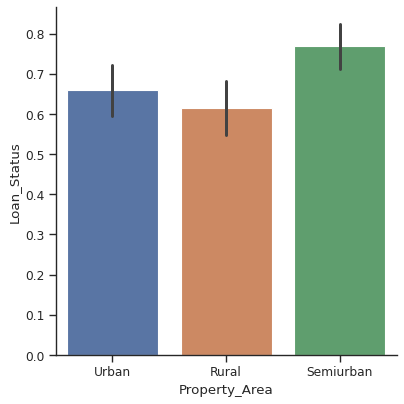

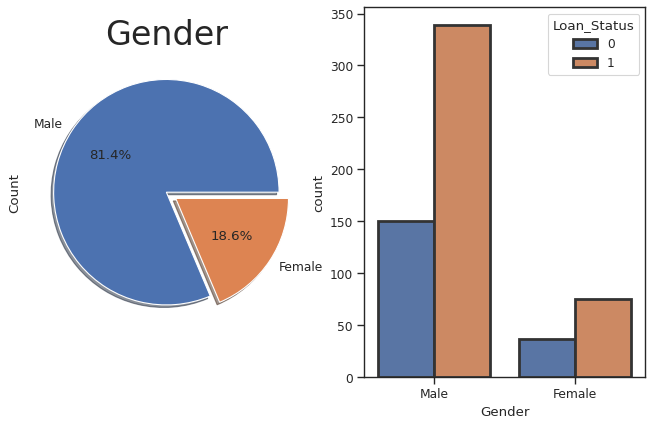

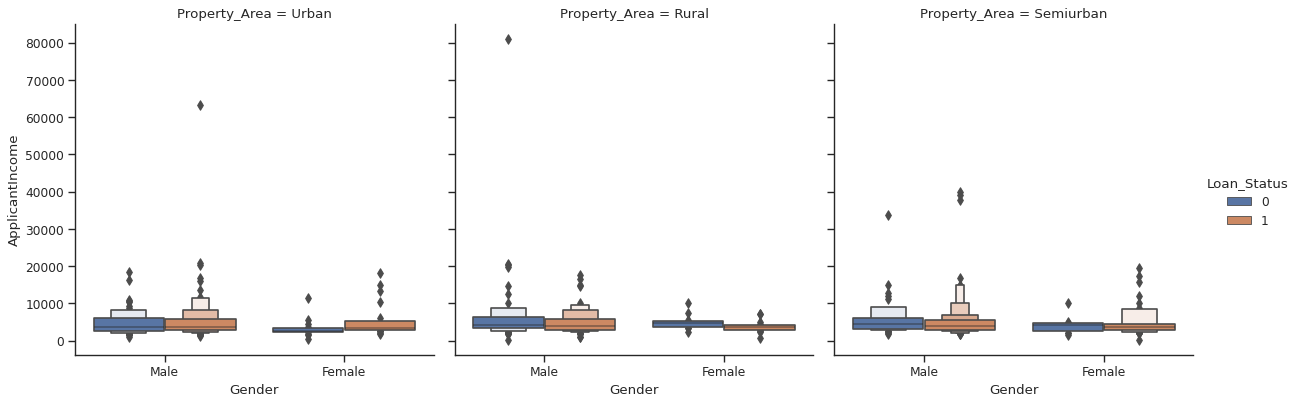

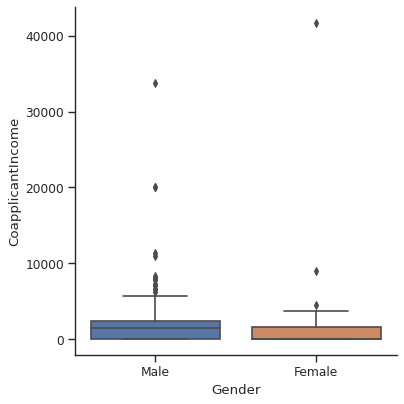

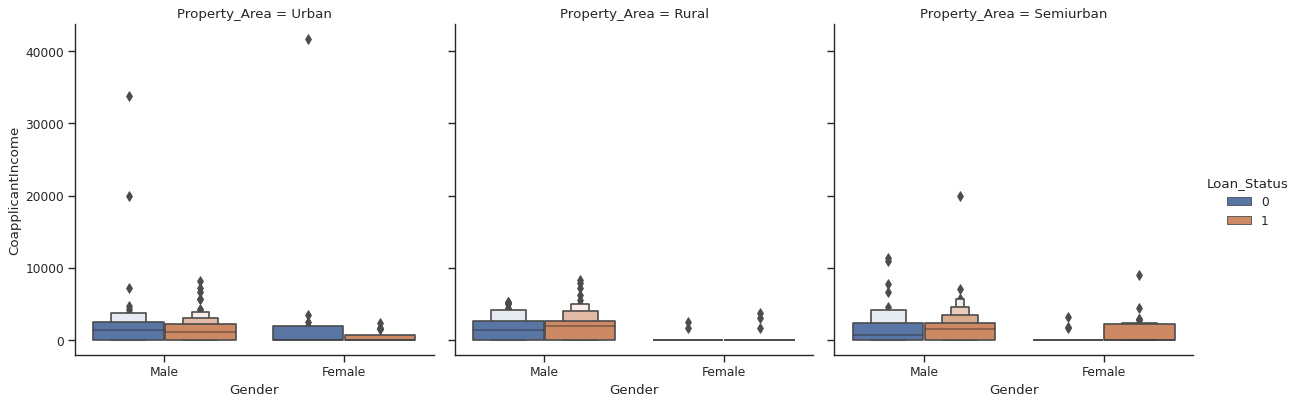

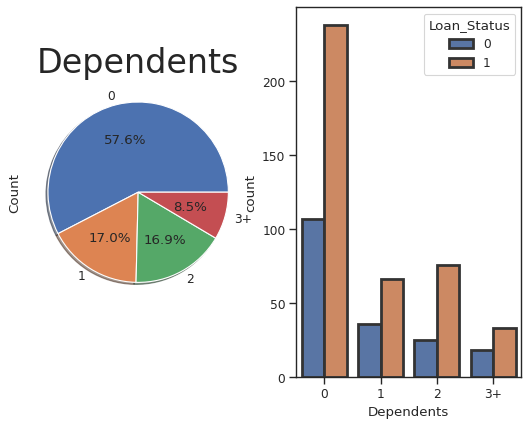

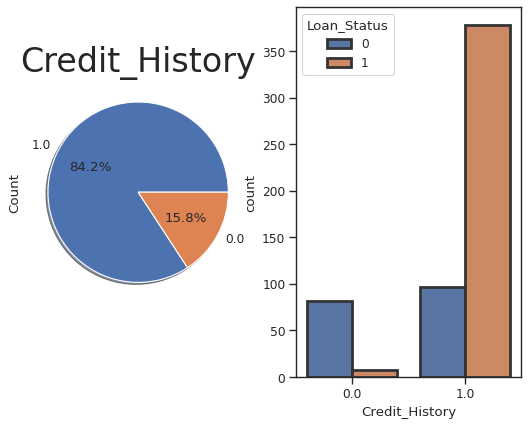

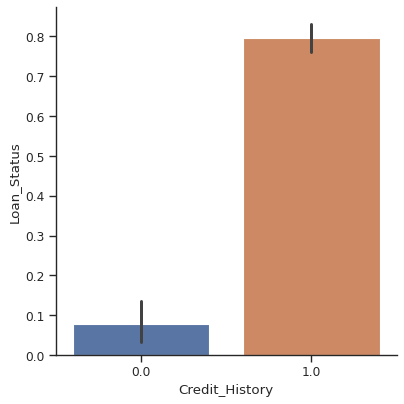

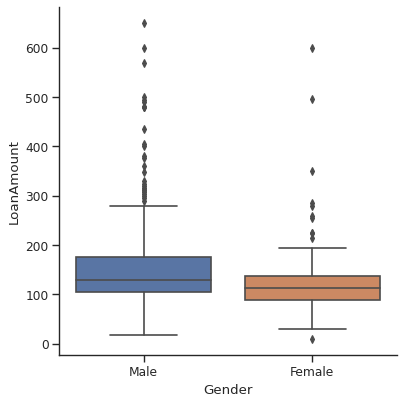

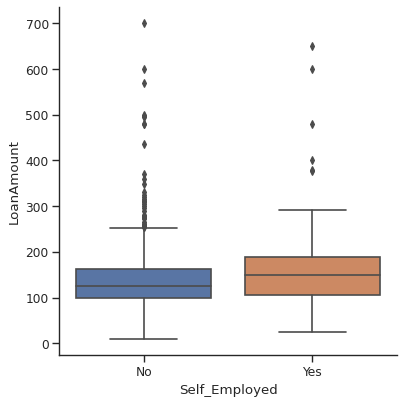

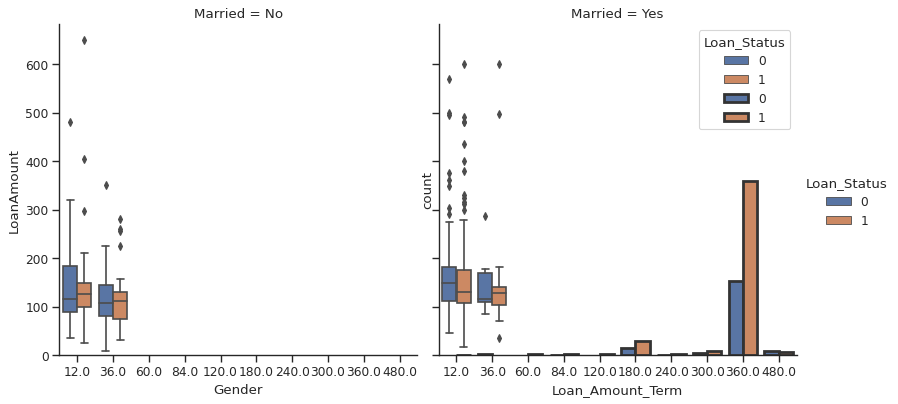

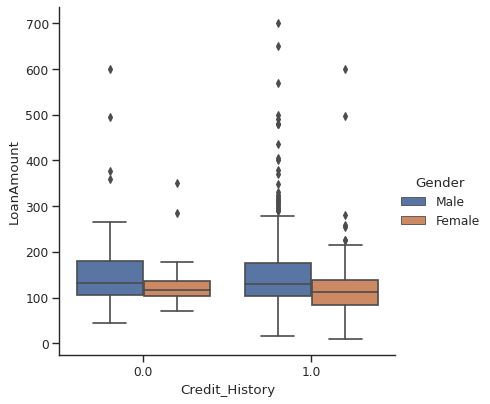

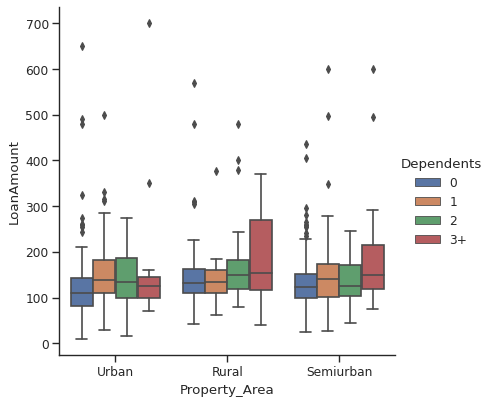

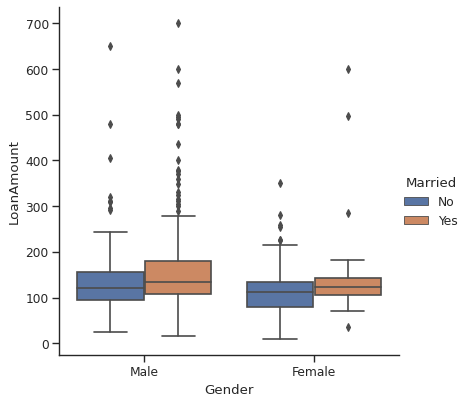

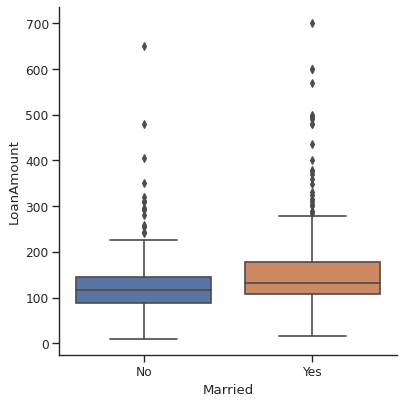

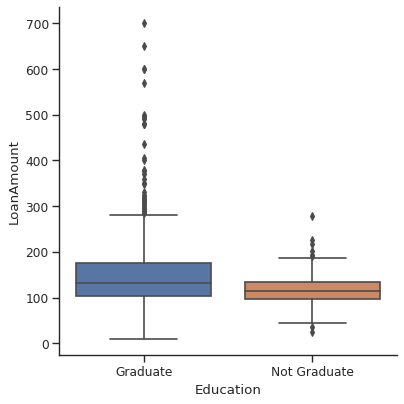

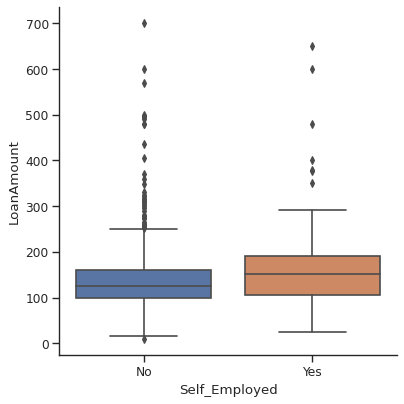

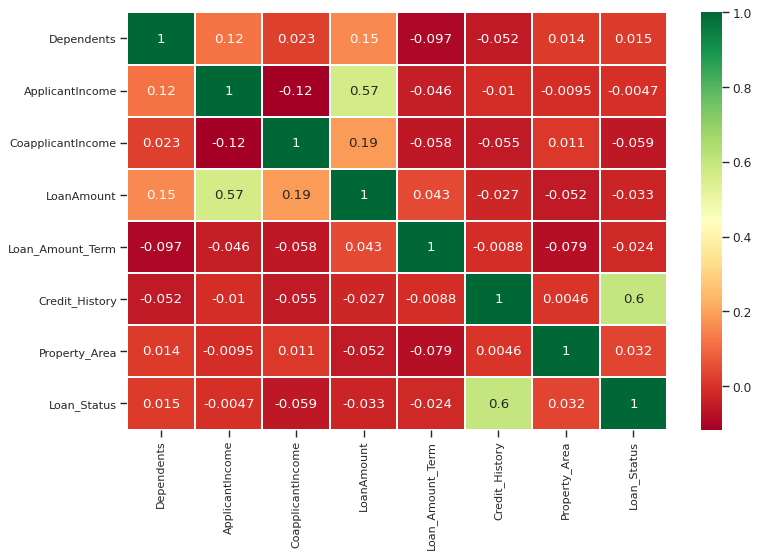

In [48]:
#Final Pair plot
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [49]:
#Combine train and test datasets
combine_set=pd.concat([train_df,test_df], ignore_index=True)
combine_set.shape

(981, 12)

### FEATURE ENGINEERING

In [50]:
#Add new features - Total income
combine_set['Total_Income'] = combine_set['ApplicantIncome'] + combine_set['CoapplicantIncome']

#Dropping unwanted columns - 'ApplicantIncome','CoapplicantIncome'
combine_set.drop(['ApplicantIncome','CoapplicantIncome'],axis=1,inplace=True)

# Categorical variables wise sum of numerical columns
combine_set['Credit_History_Income_Sum']=combine_set.groupby(['Credit_History'])['Total_Income'].transform('sum')
combine_set['Dependents_LoanAmount_Sum']=combine_set.groupby(['Dependents'])['LoanAmount'].transform('sum')

#EMI
#Lets assume that interest rate=10.0 # hence r = ((10/12)/100) = 0.00833

r = 0.00833
combine_set['EMI']=combine_set.apply(lambda x: (x['LoanAmount']*r*((1+r)**x['Loan_Amount_Term']))/((1+r)**((x['Loan_Amount_Term'])-1)),axis=1)

# Categorical variables wise mean of EMI
combine_set['Dependents_EMI_mean']=combine_set.groupby(['Dependents'])['EMI'].transform('mean')

# LoanAmount_per_Total_Income
combine_set['LoanAmount_per_Total_Income']=combine_set['LoanAmount']/combine_set['Total_Income']

# Loan_Amount_Term_per_Total_Income
combine_set['Loan_Amount_Term_per_Total_Income']=combine_set['Loan_Amount_Term']/combine_set['Total_Income']

# EMI_per_Loan_Amount_Term
combine_set['EMI_per_Loan_Amount_Term']=combine_set['EMI']/combine_set['Loan_Amount_Term']

# EMI_per_LoanAmount
combine_set['EMI_per_LoanAmount']=combine_set['EMI']/combine_set['LoanAmount']

# Categorical variables wise mean of LoanAmount_per_Total_Income
combine_set['Property_Area_LoanAmount_per_Total_Income_mean']=combine_set.groupby(['Property_Area'])['LoanAmount_per_Total_Income'].transform('mean')


################################# Bin formation ###############################################

Loan_Amount_Term_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
combine_set['Loan_Amount_Term_Bins'] = Loan_Amount_Term_discretizer.fit_transform(combine_set['Loan_Amount_Term'].values.reshape(-1,1)).astype(float)

Total_Income_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
combine_set['Total_Income_Bins'] = Total_Income_discretizer.fit_transform(combine_set['Total_Income'].values.reshape(-1,1)).astype(float)

LoanAmount_per_Total_Income_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
combine_set['LoanAmount_per_Total_Income_Bins'] = LoanAmount_per_Total_Income_discretizer.fit_transform(combine_set['LoanAmount_per_Total_Income'].values.reshape(-1,1)).astype(float)

In [51]:
#Drop unwanted columns
combine_set=combine_set.drop(['EMI'],axis=1)
combine_set=combine_set.drop(['Total_Income'],axis=1)
combine_set=combine_set.drop(['LoanAmount_per_Total_Income'],axis=1)

In [52]:
combine_set

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_Income_Sum,Dependents_LoanAmount_Sum,Dependents_EMI_mean,Loan_Amount_Term_per_Total_Income,EMI_per_Loan_Amount_Term,EMI_per_LoanAmount,Property_Area_LoanAmount_per_Total_Income_mean,Loan_Amount_Term_Bins,Total_Income_Bins,LoanAmount_per_Total_Income_Bins
0,Male,No,0,Graduate,No,105000.0,360.0,1.0,2,1.0,5.550332e+06,72780000.0,1121.665182,0.061549,2.449822,0.008399,23.363190,1.0,2.0,1.0
1,Male,Yes,1,Graduate,No,128000.0,360.0,1.0,0,0.0,5.550332e+06,24891000.0,1244.459459,0.059104,2.986449,0.008399,23.988448,1.0,3.0,1.0
2,Male,Yes,0,Graduate,Yes,66000.0,360.0,1.0,2,1.0,5.550332e+06,72780000.0,1121.665182,0.120000,1.539888,0.008399,23.363190,1.0,0.0,1.0
3,Male,Yes,0,Not Graduate,No,120000.0,360.0,1.0,2,1.0,5.550332e+06,72780000.0,1121.665182,0.072860,2.799796,0.008399,23.363190,1.0,2.0,2.0
4,Male,No,0,Graduate,No,141000.0,360.0,1.0,2,1.0,5.550332e+06,72780000.0,1121.665182,0.060000,3.289761,0.008399,23.363190,1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Male,Yes,3,Not Graduate,Yes,113000.0,360.0,1.0,2,NaN,5.550332e+06,15406000.0,1421.988850,0.062219,2.636475,0.008399,23.363190,1.0,2.0,1.0
977,Male,Yes,0,Graduate,No,115000.0,360.0,1.0,2,NaN,5.550332e+06,72780000.0,1121.665182,0.073968,2.683138,0.008399,23.363190,1.0,2.0,2.0
978,Male,No,0,Graduate,No,126000.0,360.0,1.0,1,NaN,5.550332e+06,72780000.0,1121.665182,0.068663,2.939786,0.008399,24.764241,1.0,2.0,2.0
979,Male,Yes,0,Graduate,No,158000.0,360.0,1.0,0,NaN,5.550332e+06,72780000.0,1121.665182,0.048695,3.686398,0.008399,23.988448,1.0,3.0,1.0


In [53]:
#Segregate train and test
train_df=combine_set[combine_set['Loan_Status'].isnull()==False]
test_df=combine_set[combine_set['Loan_Status'].isnull()==True]

In [54]:
#Label encode categorical variables using get_dummies()
train_df = pd.get_dummies(train_df, drop_first = True)
test_df = pd.get_dummies(test_df, drop_first = True)

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 20 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Dependents                                      614 non-null    int64  
 1   LoanAmount                                      614 non-null    float64
 2   Loan_Amount_Term                                614 non-null    float64
 3   Credit_History                                  614 non-null    float64
 4   Property_Area                                   614 non-null    int64  
 5   Loan_Status                                     614 non-null    float64
 6   Credit_History_Income_Sum                       614 non-null    float64
 7   Dependents_LoanAmount_Sum                       614 non-null    float64
 8   Dependents_EMI_mean                             614 non-null    float64
 9   Loan_Amount_Term_per_Total_Income          

In [56]:
#Drop target variable from X and copy to y
X = train_df.drop(['Loan_Status'],axis=1)
y = train_df['Loan_Status']

#Drop target column (which is blank) from test dataset
X_main_test=test_df.drop(['Loan_Status'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

In [57]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

### Custom class for prediction and probability 

In [58]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input=None):
        import logging
        import numpy as np
        
        if model_input is None:
            model_input=context
        
        logger = logging.getLogger()
        logger.info(f'model_input={model_input}')
        model_input["data"][0] = np.array(model_input["data"][0])

        probability = self.model.predict_proba(model_input)[:,1]
        status = self.model.predict(model_input)
        
        output = [ {"probability": probability[i], "Loan_Status": status[i] } for i in range(0, len(probability))]
        
        return output

### ML

#### Random Forest

In [59]:
with mlflow.start_run(run_name='Random Forest Classifier', experiment_id=EXPERIMENT_ID):
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf = 10)
    random_forest.fit(X_train, y_train)

    predicted_qualities = random_forest.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(random_forest.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    
    wrappedModel = SklearnModelWrapper(random_forest)    
    mlflow.sklearn.log_model(random_forest, "model")

  RMSE: 0.41590019592802907
  MAE: 0.17297297297297298
  R2: 0.24102564102564106
  Accuracy: 83.06


#### Logistic Regression

In [60]:
with mlflow.start_run(run_name='Logistic Regression', experiment_id=EXPERIMENT_ID):
    logreg = LogisticRegression(solver='lbfgs', max_iter=110)
    logreg.fit(X_train, y_train)

    predicted_qualities = logreg.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(logreg.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    
    wrappedModel = SklearnModelWrapper(logreg)
    mlflow.sklearn.log_model(logreg, "model")

  RMSE: 0.41590019592802907
  MAE: 0.17297297297297298
  R2: 0.24102564102564106
  Accuracy: 82.74


#### Gaussian Naive Bayes

In [61]:
with mlflow.start_run(run_name='Gaussian Naive Bayes', experiment_id=EXPERIMENT_ID):
    gaussian = GaussianNB()
    gaussian.fit(X_train, y_train)

    predicted_qualities = gaussian.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(gaussian.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(gaussian)
    mlflow.sklearn.log_model(gaussian, "model")

  RMSE: 0.41590019592802907
  MAE: 0.17297297297297298
  R2: 0.24102564102564106
  Accuracy: 83.06


#### SVM

In [62]:
with mlflow.start_run(run_name='SVM', experiment_id=EXPERIMENT_ID):
    linear_svc = SVC(gamma='auto',probability=True)
    linear_svc.fit(X_train, y_train)

    predicted_qualities = linear_svc.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(linear_svc.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(linear_svc)
    mlflow.sklearn.log_model(linear_svc, "model")

  RMSE: 0.5835585150955648
  MAE: 0.34054054054054056
  R2: -0.49423076923076925
  Accuracy: 87.3


#### Decision Tree

In [63]:
with mlflow.start_run(run_name='Decision Tree', experiment_id=EXPERIMENT_ID):
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    decision_tree.fit(X_train, y_train)

    predicted_qualities = decision_tree.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(decision_tree.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(decision_tree)
    mlflow.sklearn.log_model(decision_tree, "model")

  RMSE: 0.428700109381586
  MAE: 0.1837837837837838
  R2: 0.19358974358974357
  Accuracy: 84.69


#### Linear Discriminant Analysis

In [64]:
with mlflow.start_run(run_name='Linear Discriminant Analysis', experiment_id=EXPERIMENT_ID):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    predicted_qualities = lda.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(lda.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(lda)
    mlflow.sklearn.log_model(lda, "model")

  RMSE: 0.41590019592802907
  MAE: 0.17297297297297298
  R2: 0.24102564102564106
  Accuracy: 83.22


#### KNN

In [65]:
with mlflow.start_run(run_name='KNN', experiment_id=EXPERIMENT_ID):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    predicted_qualities = knn.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(knn.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(knn)
    mlflow.sklearn.log_model(knn, "model")

  RMSE: 0.43495883620084
  MAE: 0.1891891891891892
  R2: 0.16987179487179482
  Accuracy: 82.74


#### AdaBoost

In [66]:
with mlflow.start_run(run_name='AdaBoost', experiment_id=EXPERIMENT_ID):
    adaboost = AdaBoostClassifier()
    adaboost.fit(X_train, y_train)

    predicted_qualities = adaboost.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
    accuracy = round(adaboost.score(X, y) * 100, 2)
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Accuracy: %s" % accuracy)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    wrappedModel = SklearnModelWrapper(adaboost)
    mlflow.sklearn.log_model(adaboost, "model")

  RMSE: 0.44112877325628463
  MAE: 0.1945945945945946
  R2: 0.1461538461538462
  Accuracy: 85.18


## Results

In [67]:
best_run_df = mlflow.search_runs(experiment_ids=[EXPERIMENT_ID], order_by=['metrics.accuracy DESC'], max_results=1)
best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
# best_model = pyfunc.load_model(best_model_uri)

print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print("Run Accuracy:  = {:.4f}\n".format(best_run.data.metrics['accuracy']))
print(f"Run model URI: {best_model_uri}")

Best run info:
Run id: cbe229d4e8934d9cbcd512136a1f1b64
Run Accuracy:  = 87.3000

Run model URI: s3://mlflow/11/cbe229d4e8934d9cbcd512136a1f1b64/artifacts/model


## Model Serving

In [68]:
import subprocess

api_version = 'serving.kserve.io/v1beta1'
model_name = 'loan-approval-demo2'
model_namespace = 'hpedemo-user01'

inference_service = '''
apiVersion: "{}"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
spec:
  predictor:
    serviceAccountName: kserve-minio-sa
    model:
      modelFormat:
        name: sklearn
      runtime: kserve-mlserver
      storageUri: "{}"
'''.format(api_version, model_name, model_namespace, best_model_uri)

subprocess.run('cat << EOF | kubectl apply -f -' + inference_service + 'EOF', shell=True)

inferenceservice.serving.kserve.io/loan-approval-demo3 created


CompletedProcess(args='cat << EOF | kubectl apply -f -\napiVersion: "serving.kserve.io/v1beta1"\nkind: "InferenceService"\nmetadata:\n  name: loan-approval-demo3\n  namespace: hpedemo-user01\nspec:\n  predictor:\n    serviceAccountName: kserve-minio-sa\n    model:\n      modelFormat:\n        name: sklearn\n      runtime: kserve-mlserver\n      storageUri: "s3://mlflow/11/cbe229d4e8934d9cbcd512136a1f1b64/artifacts/model"\nEOF', returncode=0)

## Prediction

In [69]:
import requests, json
import numpy as np
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

KUBEFLOW_URL = "kubeflow.hpe-staging-ezaf.com"
DEPLOYMENT_NAME = "loan-approval-demo2"
NAMESPACE="hpedemo-user01"
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.hpe-staging-ezaf.com'

URL = "https://{}/v2/models/{}/infer".format(SVC, DEPLOYMENT_NAME)

# PREDICTION_URL = KUBEFLOW_URL #"{}/seldon/{}/{}/api/v1.0/predictions".format(KUBEFLOW_URL,NAMESPACE,SELDON_DEPLOYMENT_NAME)
print(URL)

https://loan-approval-demo2-predictor-default.hpedemo-user01.hpe-staging-ezaf.com/v2/models/loan-approval-demo2/infer


In [70]:
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
     "Authorization": f"Bearer {token}"
}

Approved = {'Dependents': 0.0,
 'LoanAmount': 105000.0,
 'Loan_Amount_Term': 360.0,
 'Credit_History': 1.0,
 'Property_Area': 2.0,
 'Credit_History_Income_Sum': 5550331.91998864,
 'Dependents_LoanAmount_Sum': 72780000.0,
 'Dependents_EMI_mean': 1121.6651819119277,
 'Loan_Amount_Term_per_Total_Income': 0.06154898273209095,
 'EMI_per_Loan_Amount_Term': 2.4498217625000005,
 'EMI_per_LoanAmount': 0.008399388900000002,
 'Property_Area_LoanAmount_per_Total_Income_mean': 23.36319041854885,
 'Loan_Amount_Term_Bins': 1.0,
 'Total_Income_Bins': 2.0,
 'LoanAmount_per_Total_Income_Bins': 1.0,
 'Loan_Amount_Term_per_Total_Income': 0.125,
 'Gender_Male': 1.0,
 'Married_Yes': 0.0,
 'Education_Not Graduate': 0.0,
 'Self_Employed_Yes': 0.0
}

Declined = {'Dependents': 0.0,
 'LoanAmount': 74000.0,
 'Loan_Amount_Term': 360.0,
 'Credit_History': 1.0,
 'Property_Area': 2.0,
 'Credit_History_Income_Sum': 5550331.91998864,
 'Dependents_LoanAmount_Sum': 72780000.0,
 'Dependents_EMI_mean': 1121.6651819119277,
 'Loan_Amount_Term_per_Total_Income': 0.09130103981739791,
 'EMI_per_Loan_Amount_Term': 1.7265410516666668,
 'EMI_per_LoanAmount': 0.0083993889,
 'Property_Area_LoanAmount_per_Total_Income_mean': 23.36319041854885,
 'Loan_Amount_Term_Bins': 1.0,
 'Total_Income_Bins': 1.0,
 'LoanAmount_per_Total_Income_Bins': 1.0,
 'Gender_Male': 1.0,
 'Married_Yes': 0.0,
 'Education_Not Graduate': 0.0,
 'Self_Employed_Yes': 0.0
}

In [71]:
inputs = {
  "inputs": [
    { 
      "name": "ndarray",
      "shape": [2,19],
      "datatype": "FP32",
      "data": [
        list(Approved.values()),
        list(Declined.values())  
      ]
    }
  ],
    "outputs": [
        {
            "name": "predict"
        },
        {
            "name": "predict_proba"
        }
    ]
}

In [72]:
json_request = json.dumps(inputs)
response = requests.post(URL, headers=headers, data=json_request, verify=False)
outputs = response.json()["outputs"]
print(outputs)

[{'name': 'predict', 'shape': [2], 'datatype': 'FP64', 'parameters': None, 'data': [1.0, 0.0]}, {'name': 'predict_proba', 'shape': [2, 2], 'datatype': 'FP64', 'parameters': None, 'data': [0.31266143384024964, 0.6873385661597506, 0.5088440667530835, 0.4911559332469165]}]


### Approved

In [73]:
status = outputs[0]["data"][0]
probability = np.array(outputs[1]["data"])[1]

output = {"probability": probability, "Loan_Status": status }
print("Prediction: {}\nProbability: {:.2f}".format(output["Loan_Status"],output["probability"]))

Prediction: 1.0
Probability: 0.69


### Declined

In [74]:
status = outputs[0]["data"][1]
probability = np.array(outputs[1]["data"])[3]

output = {"probability": probability, "Loan_Status": status }
print("Prediction: {}\nProbability: {:.2f}".format(output["Loan_Status"],output["probability"]))

Prediction: 0.0
Probability: 0.49


### Multi Model Serving

In [ ]:
# Copy s3cert.crt certificate from s3 storage and save it in example directory and run command:
!kubectl create configmap s3-cert --from-file=s3cert.crt

In [ ]:
multi_inference_service = '''
apiVersion: "{}"
kind: "InferenceService"
metadata:
  name: {}
  namespace: {}
  labels:
    serving.kserve.io/multimodel-serving-mode: "true"
spec:
  predictor:
    serviceAccountName: kserve-minio-sa
    sklearn:
      protocolVersion: v1
      resources:
        limits:
          cpu: 100m
          memory: 512Mi
        requests:
          cpu: 100m
          memory: 512Mi
'''.format(api_version, model_name, model_namespace)

subprocess.run('cat << EOF | kubectl apply -f -' + multi_inference_service + 'EOF', shell=True)

In [ ]:
model_trained_name = 'loan-model'

trained_model = '''
apiVersion: {}
kind: "TrainedModel"
metadata:
  name: {}
  namespace: {}
spec:
  inferenceService: "loan-approval-demo"
  model:
    storageUri: {}
    framework: "sklearn"
    memory: "128Mi"
'''.format(multi_api_version, model_trained_name, model_namespace, best_model_uri)

subprocess.run('cat << EOF | kubectl apply -f -' + trained_model + 'EOF', shell=True)

### MultiModel Prediction

In [ ]:
DEPLOYMENT_NAME = "loan-approval-demo"
NAMESPACE="hpedemo-user01"
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.svc.cluster.local'

URL = "https://{}/v1/models/{}:predict".format(SVC, model_trained_name)

print(URL)

In [ ]:
json_request = json.dumps(inputs)
response = requests.post(URL, headers=headers, cookies=cookies, data=json_request, verify=False)
outputs = response.json()
print(outputs)